#Mô hình TFIDF kết hợp Random Forest

##Khai báo thư viện
Trong bài này, chúng ta sẽ sử dụng trực tiếp mô hình TFIDF và Random Forest của thư viện sklearn. Bên cạnh đó, thư viện nltk được sử dụng để tiền xử lí dữ liệu dạng text thành dạng chuẩn trước khi cho vào để vector hóa qua mô hình TFIDF.

In [16]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import re
import string

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


##Tiền xử lý dữ liệu dạng text
Để xử lí dữ liệu dạng text, chúng ta cần trải qua những bước sau: 
+ chuyển hết kí tự viết hoa thành viết thường
+ loại bỏ hết những kí tự ngoại trừ các kí tự từ a-z, A-Z, 0-9, !,...
+ loại bỏ hết các loại dấu trong text thành kí tự rỗng 
+ loại bỏ hết các stop word (stop word là những từ xuất hiện nhiều nhưng không đóng vai trò quan trọng về ý nghĩa với đoạn text)
+ đưa tất cả các từ về một định dạng (lemmatizer)

In [17]:
stop_words = stopwords.words('english')
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z?.!,¿0-9]+", " ", text)
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,_' + "'`"
    for p in punctuations:
        text = text.replace(p,'')
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

##Xây dựng mô hình(TFIDF + Random Forest)
Chu trình thực hiện model:
Tiền xử lý -> Vector hóa(sử dụng mô hình TFIDF) -> Sử dụng mô hình RF -> In ra báo cáo
+ Tiền xử lý: Sử dụng hàm tiền xử lý đã được triển khai ở phần trên
+ Vector hóa: Sử dụng mô hình TFIDF để chuyển file dạng text sang dataset dạng vector.
+ Sử dụng mô hình RF.
+ In ra báo cáo: Chúng ta sẽ sử dụng method classification_report của sklearn để in ra f1_score, acc của từng class. Sau đó sẽ in ra ma trận nhầm lẫn dựa vào kết quả dự đoán và kết quả thực tế.


In [18]:
class Model(object):
    def __init__(self):
        f = open('sensitive_train.json')
        self.data_train = json.load(f)
        f.close()
        f = open('sensitive_test.json')
        self.data_test = json.load(f)
        f.close()
        self.train = []
        self.label_train = []
        self.test = []
        self.label_test = []
        self.feature_names = []
        self.predict = None
        
    def PreProcessing(self):
        for data in self.data_train:
            self.train.append(clean_text(data['text']))
            self.label_train.append(data['label'])
        for data in self.data_test:
            self.test.append(clean_text(data['text']))
            self.label_test.append(data['label'])
        
    def Vectorizer(self):
        self.tfidf_vectorizer = TfidfVectorizer(smooth_idf = False)
        self.tfidf_train_vectors = self.tfidf_vectorizer.fit_transform(self.train)
        self.tfidf_test_vectors = self.tfidf_vectorizer.transform(self.test)
        self.feature_names = self.tfidf_vectorizer.get_feature_names_out()
        
    def Run(self):
        self.PreProcessing()
        self.Vectorizer()
        self.classifier = RandomForestClassifier()
        self.classifier.fit(self.tfidf_train_vectors, self.label_train)
        self.predict = self.classifier.predict(self.tfidf_test_vectors)
        print(classification_report(self.label_test, self.predict))
        acc = 0
        for i in range(len(self.label_test)):
            if self.label_test[i] == self.predict[i]:
                acc += 1
        cm = confusion_matrix(self.label_test, self.predict)
        _display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = self.classifier.classes_)
        _display.plot()
        plt.show()

##Chạy chương trình

              precision    recall  f1-score   support

      insult       0.96      0.65      0.77       205
     neutral       0.51      0.86      0.64       270
    politics       0.70      0.42      0.53       174
    religion       0.94      0.67      0.78       159
   terrorism       0.84      0.82      0.83       211

    accuracy                           0.70      1019
   macro avg       0.79      0.68      0.71      1019
weighted avg       0.77      0.70      0.71      1019



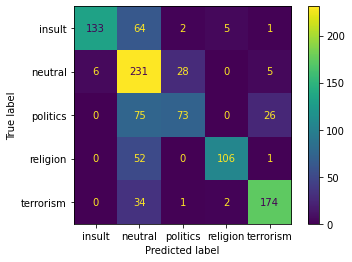

In [19]:
t = Model()
t.Run()